In [29]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from gym import wrappers
from gym import spaces
import math
import random
from IPython.display import clear_output

In [30]:
global total_step_count_each_episode
total_step_count_each_episode=10
global total_episodes_to_run
total_episodes_to_run=3
global last_episode_step_count
last_episode_step_count=30

In [31]:
global total_step_count_each_episode
total_step_count_each_episode=1000
global total_episodes_to_run
total_episodes_to_run=30
global last_episode_step_count
last_episode_step_count=1000

In [32]:
use_custom=True

In [33]:
df_sklearn=pd.read_csv("data1.csv",index_col=0)

In [34]:
df_sklearn

,burst_allowance,drop_prob,current_qdelay,qdelay_old,accu_prob,measurement_start,tot_pkts,tot_bytes,length,len_bytes,drops,ecn
0,1.000000,-0.999988,-0.3125,0.020833,0.0,0.001496,0.000392,0.000287,0.003257,0.003690,0.000000,0
1,1.000000,-1.000000,-0.0000,0.000000,0.0,0.001621,0.000637,0.000568,0.000000,0.000000,0.000000,0
2,1.000000,-0.999988,-0.3125,0.020833,0.0,0.002494,0.001201,0.001013,0.013029,0.011198,0.000000,0
3,1.000000,-0.999988,-0.3125,0.020833,0.0,0.002660,0.001618,0.001512,0.019544,0.018578,0.000000,0
4,0.888889,-0.999990,-0.3125,0.020833,0.0,0.002660,0.001716,0.001636,0.003257,0.003690,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4750,0.777778,-1.000000,-0.6250,0.041667,0.0,0.998670,0.195665,0.247684,0.022801,0.025829,0.435841,1
4751,0.555556,-0.999971,-1.2500,0.083333,0.0,0.998545,0.136900,0.027735,0.087948,0.042636,0.000000,0
4752,0.444444,-0.999920,-1.2500,0.083333,0.0,0.998545,0.136900,0.027735,0.035831,0.022779,0.000000,0
4753,0.666667,-0.999985,-0.9375,0.062500,0.0,0.998670,0.195739,0.247724,0.013029,0.008369,0.435841,1


In [35]:
#@title Custom Gym Environment
observations = ['burst_allowance',
 'drop_prob',
 'current_qdelay',
 'qdelay_old',
 'accu_prob',
 'measurement_start',
 'tot_pkts',
 'tot_bytes',
 'length',
 'len_bytes',
 'drops',
 'ecn']

observations=list(df_sklearn.columns)

actions=['new_drop_prob']



states_dict={}



def tcp_obs_space():
    lower_obs_bound = {
        'burst_allowance': - np.inf,
        'drop_prob': - np.inf,
        'current_qdelay': - np.inf,
        'qdelay_old': - np.inf,
        'accu_prob': - np.inf,
        'measurement_start': - np.inf,
        'tot_pkts': - np.inf,
        'tot_bytes': - np.inf,
        'length': - np.inf,
        'len_bytes': - np.inf,
        'drops': - np.inf,
        'ecn': - np.inf
        
    }

    higher_obs_bound = {
        'burst_allowance': np.inf,
        'drop_prob': np.inf,
        'current_qdelay': np.inf,
        'qdelay_old': np.inf,
        'accu_prob': np.inf,
        'measurement_start': np.inf,
        'tot_pkts': np.inf,
        'tot_bytes': np.inf,
        'length': np.inf,
        'len_bytes': np.inf,
        'drops': np.inf,
        'ecn': np.inf
        
    }

    low = np.array([lower_obs_bound[o] for o in observations])
    high = np.array([higher_obs_bound[o] for o in observations])
    shape = (len(observations),)
    return gym.spaces.Box(low,high,shape)


def tcp_action_space():
    lower_obs_bound = {
        'new_drop_prob': - np.inf,
    }
    higher_obs_bound = {
        'new_drop_prob': np.inf,
    }

    low = np.array([lower_obs_bound[o] for o in actions])
    high = np.array([higher_obs_bound[o] for o in actions])
    shape = (len(observations),)
    return gym.spaces.Box(low,high,shape)

In [37]:
class gym_env_entire():
    """ """
    def __init__(self,filename):

        self.filename=filename
        
        self.df_sklearn=pd.read_csv(filename,index_col=0)

        self.observations = ['burst_allowance','drop_prob','current_qdelay','qdelay_old','accu_prob',
                             'measurement_start','tot_pkts','tot_bytes','length','len_bytes','drops','ecn']
        
        self.observation_space = tcp_obs_space()


        self.state_nos=0
    
        self.ep_count=0
        self.action_space = spaces.Box(low=-np.inf,high=np.inf,dtype=np.float32,shape=(1,))
        

    

    def observation(self):
        return np.array([self.state[o] for o in self.observations])

    def reward(self):
        return self.state['current_qdelay']

    """ reset env, return the initial state  """
    def reset(self):
        # time.sleep(1)
        self.ep_count+=1
        if self.ep_count == total_episodes_to_run-1:
            rindex=random.randint(0, 100)
            rindex=850
        rindex=random.randint(460, 1727)
        
        self.state={
            'burst_allowance': self.df_sklearn.iloc[rindex]["burst_allowance"],
            'drop_prob': df_sklearn.iloc[rindex]["drop_prob"],
            'current_qdelay': self.df_sklearn.iloc[rindex]["current_qdelay"],
            'qdelay_old': self.df_sklearn.iloc[rindex]["qdelay_old"],
            'accu_prob': self.df_sklearn.iloc[rindex]["accu_prob"],
            'measurement_start': self.df_sklearn.iloc[rindex]["measurement_start"],
            'tot_pkts': self.df_sklearn.iloc[rindex]["tot_pkts"],
            'tot_bytes': self.df_sklearn.iloc[rindex]["tot_bytes"],
            'length': self.df_sklearn.iloc[rindex]["length"],
            'len_bytes': self.df_sklearn.iloc[rindex]["len_bytes"],
            'drops': self.df_sklearn.iloc[rindex]["drops"],
            'ecn': self.df_sklearn.iloc[rindex]["ecn"]
        }

        print("reset happened")
        # print(self.df_sklearn.iloc[rindex]['current_qdelay'])
        self.state_nos=0

        return self.observation()
        

    """ action = [sub1_buff_size, sub2_buff_size] """
    def step(self, action):
        # A = [self.fd, action[0], action[1]]
        # mpsched.set_seg(A)
        # time.sleep(2)
        done = False       
        
        #state_nxt = mpsched.get_sub_info(self.fd)

        input=action[0]

        if(math.isnan(input) or input<-1 or input >1):
          input=0
          print("step happened")
          print("Wrong action value")
          print(input)
          return self.observation(), self.reward(), done, {}


        df_sort = self.df_sklearn.iloc[(self.df_sklearn['drop_prob']-input).abs().argsort()[:1]]


        state_nxt={
            'burst_allowance': df_sort["burst_allowance"].values[0],
            'drop_prob': df_sort["drop_prob"].values[0],
            'current_qdelay': df_sort["current_qdelay"].values[0],
            'qdelay_old': df_sort["qdelay_old"].values[0],
            'accu_prob': df_sort["accu_prob"].values[0],
            'measurement_start': df_sort["measurement_start"].values[0],
            'tot_pkts': df_sort["tot_pkts"].values[0],
            'tot_bytes': df_sort["tot_bytes"].values[0],
            'length': df_sort["length"].values[0],
            'len_bytes': df_sort["len_bytes"].values[0],
            'drops': df_sort["drops"].values[0],
            'ecn': df_sort["ecn"].values[0]
        }        
        
        if len(state_nxt) == 0:
            done = True


        self.state_nos=self.state_nos+1
        
        if self.ep_count == total_episodes_to_run-1 and self.state_nos > last_episode_step_count:
            done=True            
        elif(self.ep_count < (total_episodes_to_run -1) and self.state_nos>total_step_count_each_episode):
            done=True

       
        if self.state['current_qdelay']==(self.df_sklearn["current_qdelay"].max()+1):
            done = True
        print("self.state_nos",self.state_nos)
        self.state=state_nxt        
        return self.observation(), self.reward(), done, {}


In [38]:
global reward_list
reward_list=[]

global episode_reward_list
episode_reward_list=[]

In [39]:
# import wandb
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda

import gym
import argparse
import numpy as np
from threading import Thread
from multiprocessing import cpu_count
tf.keras.backend.set_floatx('float64')
# wandb.init(name='A3C', project="deep-rl-tf2")



# args_gamma=0.99
# args_update_interval=5
# args_actor_lr=0.0005
# args_critic_lr=0.001

args_gamma=0.99
args_update_interval=5
args_actor_lr=0.00005
args_critic_lr=0.0001









CUR_EPISODE = 0

class Actor:
    def __init__(self, state_dim, action_dim, action_bound, std_bound):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.std_bound = std_bound
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(args_actor_lr)
        self.entropy_beta = 0.01

    def create_model(self):
        state_input = Input((self.state_dim,))
        dense_1 = Dense(32, activation='relu')(state_input)
        dense_2 = Dense(32, activation='relu')(dense_1)
        out_mu = Dense(self.action_dim, activation='tanh')(dense_2)
        mu_output = Lambda(lambda x: x * self.action_bound)(out_mu)
        std_output = Dense(self.action_dim, activation='softplus')(dense_2)
        return tf.keras.models.Model(state_input, [mu_output, std_output])

    def get_action(self, state):
        state = np.reshape(state, [1, self.state_dim])
        mu, std = self.model.predict(state)
        mu, std = mu[0], std[0]        
        return np.random.normal(mu, std, size=self.action_dim)

    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / \
            var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    def compute_loss(self, mu, std, actions, advantages):
        log_policy_pdf = self.log_pdf(mu, std, actions)
        loss_policy = log_policy_pdf * advantages
        return tf.reduce_sum(-loss_policy)

    def train(self, states, actions, advantages):
        with tf.GradientTape() as tape:
            mu, std = self.model(states, training=True)
            loss = self.compute_loss(mu, std, actions, advantages)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


class Critic:
    def __init__(self, state_dim):
        self.state_dim = state_dim
        self.model = self.create_model()
        self.opt = tf.keras.optimizers.Adam(args_critic_lr)

    def create_model(self):
        return tf.keras.Sequential([
            Input((self.state_dim,)),
            Dense(32, activation='relu'),
            Dense(32, activation='relu'),
            Dense(16, activation='relu'),
            Dense(1, activation='linear')
        ])

    def compute_loss(self, v_pred, td_targets):
        mse = tf.keras.losses.MeanSquaredError()
        return mse(td_targets, v_pred)

    def train(self, states, td_targets):
        with tf.GradientTape() as tape:
            v_pred = self.model(states, training=True)
            assert v_pred.shape == td_targets.shape
            loss = self.compute_loss(v_pred, tf.stop_gradient(td_targets))
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss


class Agent:
    def __init__(self, env_name):
        env = gym.make(env_name)
        if use_custom:
            env = gym_env_entire(filename="data1.csv")
        self.env_name = env_name       
        
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.action_bound = 1.000
        
        
        
        
        
        self.std_bound = [1e-2, 1.0]

        self.global_actor = Actor(
            self.state_dim, self.action_dim, self.action_bound, self.std_bound)
        self.global_critic = Critic(self.state_dim)
        self.num_workers = 4

    def train(self, max_episodes=100):
        workers = []

        for i in range(self.num_workers):
            env = gym.make(self.env_name)
            if use_custom:
                env = gym_env_entire(filename="data"+str(i+1)+".csv")
                #print("data"+str(i+1)+".csv")
            agentindex=i
            workers.append(WorkerAgent(
                env, self.global_actor, self.global_critic, max_episodes,agentindex))

        for worker in workers:
            worker.start()

        for worker in workers:
            worker.join()


class WorkerAgent(Thread):
    def __init__(self, env, global_actor, global_critic, max_episodes,agentindex):
        Thread.__init__(self)
        self.env = env
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        self.action_bound = 1.000
        self.std_bound = [1e-2, 1.0]

        self.max_episodes = max_episodes
        self.agentindex=agentindex
        self.global_actor = global_actor
        self.global_critic = global_critic
        self.actor = Actor(self.state_dim, self.action_dim,
                           self.action_bound, self.std_bound)
        self.critic = Critic(self.state_dim)

        self.actor.model.set_weights(self.global_actor.model.get_weights())
        self.critic.model.set_weights(self.global_critic.model.get_weights())

    def n_step_td_target(self, rewards, next_v_value, done):
        td_targets = np.zeros_like(rewards)
        cumulative = 0
        if not done:
            cumulative = next_v_value

        for k in reversed(range(0, len(rewards))):
            cumulative = args_gamma * cumulative + rewards[k]
            td_targets[k] = cumulative
        return td_targets

    def advatnage(self, td_targets, baselines):
        return td_targets - baselines

    def list_to_batch(self, list):
        batch = list[0]
        for elem in list[1:]:
            batch = np.append(batch, elem, axis=0)
        return batch

    def train(self):
        global CUR_EPISODE
        episode_reward_list_temp=[]
        

        while self.max_episodes >= CUR_EPISODE:
            state_batch = []
            action_batch = []
            reward_batch = []
            dict_row_list=[]
            
            episode_reward, done = 0, False

            state = self.env.reset()
            clear_output(wait=True)
            

            while not done:
                
                # self.env.render()
                if use_custom:
                    action = self.actor.get_action(state)
                else:
                    action = self.actor.get_action(state)[0]
                
                
                action = np.clip(action, -self.action_bound, self.action_bound)
                
                #print(self.env.step(action))
                
                if use_custom:
                    next_state, reward, done, info = self.env.step(action)
                else:
                    next_state, reward, done, info,_ = self.env.step(action)                    

                state = np.reshape(state, [1, self.state_dim])
                action = np.reshape(action, [1, 1])
                next_state = np.reshape(next_state, [1, self.state_dim])
                reward = np.reshape(reward, [1, 1])

                state_batch.append(state)
                action_batch.append(action)
                reward_batch.append(reward)
                print("Episode Number: ", CUR_EPISODE)
                
                row_dict = {'burst_allowance':state[0][0],'drop_prob':state[0][1],'current_qdelay':state[0][2],'qdelay_old':state[0][3],
                            'accu_prob':state[0][4],'measurement_start':state[0][5],
                            'tot_pkts':state[0][6],'tot_bytes':state[0][7],
                            'length':state[0][8],'len_bytes':state[0][9],
                            'drops':state[0][10],'ecn':state[0][11],
                            'action': action[0][0],'reward': reward[0][0],
                }
                dict_row_list.append(row_dict)

                
                
                
                reward_list.append(reward)

                if len(state_batch) >= args_update_interval or done:
                    print("arg update started")
                    states = self.list_to_batch(state_batch)
                    actions = self.list_to_batch(action_batch)
                    rewards = self.list_to_batch(reward_batch)

                    next_v_value = self.critic.model.predict(next_state)
                    td_targets = self.n_step_td_target(
                        (rewards+8)/8, next_v_value, done)
                    advantages = td_targets - self.critic.model.predict(states)

                    actor_loss = self.global_actor.train(
                        states, actions, advantages)
                    critic_loss = self.global_critic.train(
                        states, td_targets)

                    self.actor.model.set_weights(
                        self.global_actor.model.get_weights())
                    self.critic.model.set_weights(
                        self.global_critic.model.get_weights())

                    state_batch = []
                    action_batch = []
                    reward_batch = []
                    td_target_batch = []
                    advatnage_batch = []                
                state = next_state[0]
                # One Step done
            # Episode Ending
            episode_reward += reward[0][0]
            print('EP{} EpisodeReward={}'.format(CUR_EPISODE, episode_reward))
            # wandb.log({'Reward': episode_reward})
            episode_reward_list_temp.append(episode_reward)
            CUR_EPISODE += 1
        dftemp=pd.DataFrame(dict_row_list)
        dftemp.to_csv("ActionStateRewardlog"+str(self.agentindex)+".csv")
        print("*_*_*__*_*_*_*_*_*__*_*_*_*__*_*_*_*__*_*_*__*_*_*_*_*_*_*_*__*_*_*_*_*_*_*_*_*_*_")
        dftemp=pd.DataFrame(episode_reward_list_temp, columns =['EpisodeReward'])
        dftemp.to_csv("RewardWorker"+str(self.agentindex)+".csv")
        print("*_*_*__*_*_*_*_*_*__*_*_*_*__*_*_*_*__*_*_*__*_*_*_*_*_*_*_*__*_*_*_*_*_*_*_*_*_*_")


    def run(self):
        self.train()


def main():
    env_name = 'Pendulum-v1'
    agent = Agent(env_name)
    agent.train(total_episodes_to_run)


if __name__ == "__main__":
    main()

1/1 [==============================] - 0s 22ms/step
EP31 EpisodeReward=-10.625
*_*_*__*_*_*_*_*_*__*_*_*_*__*_*_*_*__*_*_*__*_*_*_*_*_*_*_*__*_*_*_*_*_*_*_*_*_*_
*_*_*__*_*_*_*_*_*__*_*_*_*__*_*_*_*__*_*_*__*_*_*_*_*_*_*_*__*_*_*_*_*_*_*_*_*_*_
self.state_nos 1
Episode Number:  32
1/1 [==============================] - 0s 15ms/step
self.state_nos 1
Episode Number:  32
1/1 [==============================] - 0s 15ms/step
self.state_nos 2
Episode Number:  32
1/1 [==============================] - 0s 16ms/step
self.state_nos 2
Episode Number:  32
1/1 [==============================] - 0s 15ms/step
self.state_nos 3
Episode Number:  32
1/1 [==============================] - 0s 14ms/step
self.state_nos 3
Episode Number:  32
1/1 [==============================] - 0s 15ms/step
self.state_nos 4
Episode Number:  32
1/1 [==============================] - 0s 15ms/step
self.state_nos 4
Episode Number:  32
1/1 [==============================] - 0s 15ms/step
self.state_nos 5
Episode Number:  32
arg up

In [40]:
list_of_rewards=[]
for index in range(len(reward_list)):
    list_of_rewards.append(reward_list[index][0][0])
re_np=np.array(list_of_rewards)
import pandas as pd
reward_np_list={
    "rewards":re_np
}
df=pd.DataFrame(reward_np_list)

df.to_csv("data_reward.csv")


In [41]:
episode_reward_list
re_np=np.array(episode_reward_list)
import pandas as pd
reward_np_list={
    "rewards":re_np
}
df=pd.DataFrame(reward_np_list)

df.to_csv("episode_reward.csv")

In [45]:
reward_list[0]

array([[-6.875]])

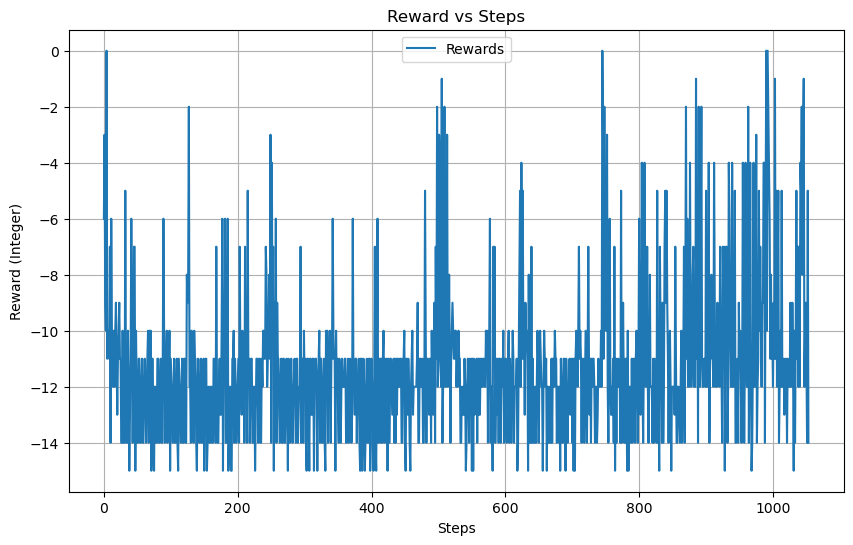

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
file_path = 'data_reward.csv'  # Adjust the file path accordingly
# Skip the header row by setting header=None
df = pd.read_csv(file_path)

# Convert 'rewards' column to integers
df['rewards'] = df['rewards'].astype(int)

# Extract the data from the DataFrame
rewards = df['rewards']

# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))  # Adjust figure size if necessary
plt.plot(df.index, rewards,label='Rewards')

# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Reward (Integer)')
plt.title('Reward vs Steps')

# Add gridlines
plt.grid(True)

# Add legend
plt.legend()

# Show plot
plt.show()
